# 01 Data Processing
## Do Federally Funded Patents Get Cited More?


#### TODO:
- deal w/ null values
- change filing date to age or yr
- decide if need to subset the 9m row final dataset
- get rid of cols not needed (cpc_type)
- filter for date 2022-present

### Import Packages

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

### Import data

In [2]:
# all patents
patents = pd.read_csv('../data/g_application.tsv', sep='\t')

# government patents
gov_patents = pd.read_csv('../data/g_gov_interest_org.tsv', sep='\t')

# citations to patents by patents, giant file
citations = pd.read_csv('../data/g_us_patent_citation.tsv', sep='\t')

# CPC topic data
cpc_current = pd.read_csv('../data/g_cpc_current.tsv', sep='\t')
cpc_titles = pd.read_csv('../data/g_cpc_title.tsv', sep='\t')

/var/folders/3m/chgnvz6n0lvb48zy37bx_p6c0000gn/T/ipykernel_56202/723068102.py:2: DtypeWarning: Columns (0,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  patents = pd.read_csv('../data/g_application.tsv', sep='\t')
/var/folders/3m/chgnvz6n0lvb48zy37bx_p6c0000gn/T/ipykernel_56202/723068102.py:8: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  citations = pd.read_csv('../data/g_us_patent_citation.tsv', sep='\t')


### Prep Data

In [3]:
citation_counts = citations.pivot_table(
    index='patent_id',
    columns='citation_category',
    aggfunc='size',
    fill_value=0
).reset_index()

citation_counts.columns.name = None
citation_counts.rename(columns={
    'cited by examiner': 'count_by_examiner',
    'cited by applicant': 'count_by_applicant',
    'cited by other': 'count_by_other',
    'cited by third party' : 'count_by_third_party',
    'imported from a related application':'imported_from_related_application'

}, inplace=True)

# Add a total count column
citation_counts['count'] = citation_counts['count_by_examiner'] + citation_counts['count_by_applicant']



We want to get topics of these patents

In [4]:
# only for inventional because we want tags related directly to invention only
primary_cpc = cpc_current[cpc_current['cpc_type']=='inventional'].groupby('patent_id', as_index=False).first()
cpc_classes  = cpc_titles.iloc[:, -2:].drop_duplicates()
primary_cpc_with_title = primary_cpc.merge(cpc_classes[['cpc_class', 'cpc_class_title']], 
                                           on='cpc_class', 
                                           how='left')
primary_cpc_with_title['patent_id'] = primary_cpc_with_title['patent_id'].astype(str)

In [5]:
primary_cpc_with_title

,patent_id,cpc_sequence,cpc_section,cpc_class,cpc_subclass,cpc_group,cpc_type,cpc_class_title
0,3930271,0,A,A63,A63B,A63B71/146,inventional,SPORTS; GAMES; AMUSEMENTS
1,3930272,0,A,A47,A47D,A47D7/02,inventional,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
2,3930273,0,A,A61,A61G,A61G7/0507,inventional,MEDICAL OR VETERINARY SCIENCE; HYGIENE
3,3930274,0,B,B63,B63B,B63B7/085,inventional,SHIPS OR OTHER WATERBORNE VESSELS; RELATED EQU...
4,3930275,0,A,A43,A43D,A43D8/08,inventional,FOOTWEAR
...,...,...,...,...,...,...,...,...
8158901,12156484,0,H,H10,H10N,H10N69/00,inventional,SEMICONDUCTOR DEVICES; ELECTRIC SOLID-STATE DE...
8158902,12156485,0,H,H10,H10N,H10N70/231,inventional,SEMICONDUCTOR DEVICES; ELECTRIC SOLID-STATE DE...
8158903,12156486,0,H,H10,H10B,H10B63/80,inventional,SEMICONDUCTOR DEVICES; ELECTRIC SOLID-STATE DE...
8158904,12156487,0,H,H10,H10N,H10N70/20,inventional,SEMICONDUCTOR DEVICES; ELECTRIC SOLID-STATE DE...


### Combine datasets

Now we have the government interest patents, all the patents, the patent CPCs, and the citation counts. We need to combine the data now.

In [6]:
# Combining the patents df and the gov_patents df
all_patents_df = pd.merge(patents, gov_patents, on='patent_id', how='left')

# Create the 'fed_funded' column based on the presence of a match in gov_patents
all_patents_df['fed_funded'] = all_patents_df['fedagency_name'].notnull().astype(int)

all_patents_df = all_patents_df[['patent_id', 'filing_date', 'fedagency_name', 'level_one', 'level_two', 'level_three', 'fed_funded']]


# Adding in CPC codes and titles
all_patents_df = pd.merge(all_patents_df, primary_cpc_with_title[['patent_id', 'cpc_section', 'cpc_class', 'cpc_subclass', 'cpc_group', 'cpc_type', 'cpc_class_title']], 
                              on='patent_id', how='left')


# Adding in the citation counts
citation_counts.rename(columns={
    'count_by_applicant': 'citations_by_applicant',
    'count_by_examiner': 'citations_by_examiner',
    'cited_by_other': 'citations_by_other',
    'cited_by_third_party': 'citations_by_third_party',
    'imported_from_related_application': 'citations_imported_from_related_application',
    'count': 'total_citations'
}, inplace=True)

all_patents_df = pd.merge(all_patents_df, citation_counts, on='patent_id', how='left')

# ADDITIONAL CLEANING STEPS:

# standarizing date --> year, filtering 2002-present
all_patents_df['filing_year'] = all_patents_df['filing_date'].str[:4].astype(int)
all_patents_df = all_patents_df[(all_patents_df['filing_year']>=2002)&(all_patents_df['filing_year']<=2025)]

# dropping unnecessary columns
all_patents_df = all_patents_df.drop(columns=['count_by_other', 'count_by_third_party', 'citations_imported_from_related_application', 'filing_date', 'cpc_type'])

# fill appropriate columns' null vlaues with 0
all_patents_df[['citations_by_examiner', 'citations_by_applicant', 'total_citations']] = all_patents_df[['citations_by_examiner', 'citations_by_applicant', 'total_citations']].fillna(0)

# removing patents that are not utility patents by removing rows without a CPC section
all_patents_df.dropna(subset=['cpc_section'], inplace=True)
all_patents_df.head(5)


,patent_id,fedagency_name,level_one,level_two,level_three,fed_funded,cpc_section,cpc_class,cpc_subclass,cpc_group,cpc_class_title,citations_by_applicant,citations_by_examiner,total_citations,filing_year
3128606,6670400,NaN,NaN,NaN,NaN,0,C,C07,C07D,C07D213/81,ORGANIC CHEMISTRY,0.0,0.0,0.0,2002
3128607,6556675,NaN,NaN,NaN,NaN,0,H,H04,H04Q,H04Q1/028,ELECTRIC COMMUNICATION TECHNIQUE,0.0,0.0,0.0,2002
3128608,6511529,NaN,NaN,NaN,NaN,0,B,B01,B01D,B01D47/00,PHYSICAL OR CHEMICAL PROCESSES OR APPARATUS IN...,0.0,0.0,0.0,2002
3128609,6618956,NaN,NaN,NaN,NaN,0,B,B04,B04B,B04B1/20,CENTRIFUGAL APPARATUS OR MACHINES FOR CARRYING...,0.0,0.0,0.0,2002
3128610,6778704,NaN,NaN,NaN,NaN,0,G,G06,G06V,G06V30/242,COMPUTING; CALCULATING OR COUNTING,0.0,0.0,0.0,2002


In [45]:
all_patents_df.to_csv('../data/input.csv')

## Visualizations

In [37]:
cpc_counts = all_patents_df['cpc_section'].value_counts()

# Generalize the abbreviations to shorter descriptions
cpc_mapping = {
    'A': 'Human Necessities',
    'B': 'Operations & Transport',
    'C': 'Chemistry & Metallurgy',
    'D': 'Textiles & Paper',
    'E': 'Fixed Constructions',
    'F': 'Mechanical Engineering & Lighting',
    'G': 'Physics',
    'H': 'Electricity',
    'Y': 'New Tech Developments & XRACs'
}
cpc_counts_generalized = cpc_counts.rename(cpc_mapping)

cpc_df = pd.DataFrame({
    'CPC Section': cpc_counts_generalized.index,
    'Count': cpc_counts_generalized.values
})


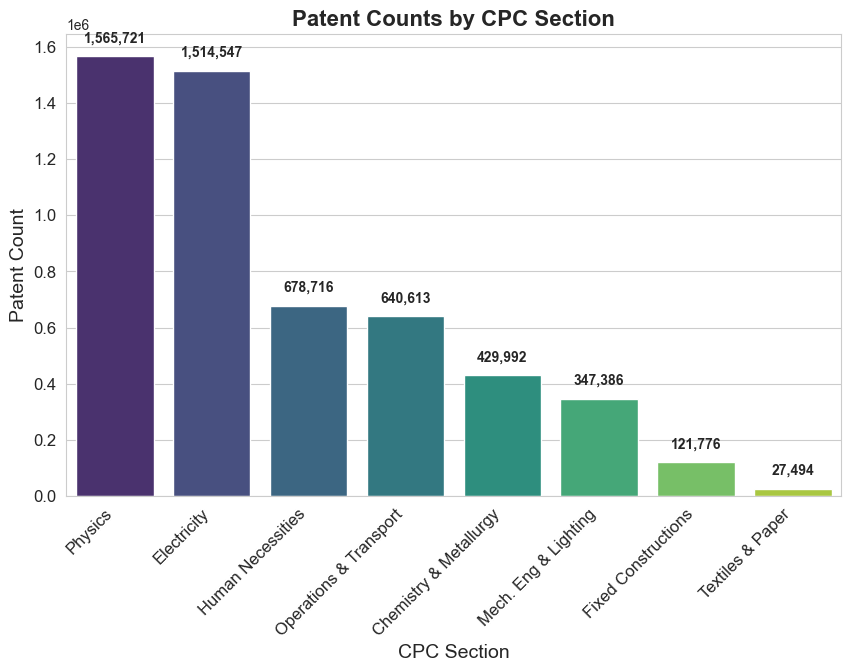

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.plotting.backend = 'plotly'

# Clean up the 'cpc_section' column: remove leading/trailing spaces
all_patents_df['cpc_section'] = all_patents_df['cpc_section'].str.strip()

# Ensure no missing values in 'cpc_section'
all_patents_df = all_patents_df.dropna(subset=['cpc_section'])

# Get value counts of 'cpc_section' (raw counts)
cpc_counts = all_patents_df['cpc_section'].value_counts()

# Generalize the abbreviations to shorter descriptions
cpc_mapping = {
    'A': 'Human Necessities',
    'B': 'Operations & Transport',
    'C': 'Chemistry & Metallurgy',
    'D': 'Textiles & Paper',
    'E': 'Fixed Constructions',
    'F': 'Mech. Eng & Lighting',
    'G': 'Physics',
    'H': 'Electricity',
    'Y': 'New Tech Developments'
}

cpc_counts = cpc_counts.rename(cpc_mapping)

cpc_df = pd.DataFrame({'CPC Section': cpc_counts.index, 'Count': cpc_counts.values})

cpc_df = cpc_df.sort_values(by='Count', ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=cpc_df, x='CPC Section', y='Count', palette="viridis")

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("CPC Section", fontsize=14)
plt.ylabel("Patent Count", fontsize=14)
plt.title("Patent Counts by CPC Section", fontsize=16, fontweight="bold")

for i, v in enumerate(cpc_df['Count']):
    ax.text(i, v + 50000, f"{v:,}", ha='center', fontsize=10, fontweight="bold")

plt.show()


In [47]:
fig = px.bar(x=['Physics',
 'Electricity',
 'Human Necessities',
 'Operations & Transport',
 'Chemistry & Metallurgy',
 'Mech. Eng & Lighting',
 'Fixed Constructions',
 'Textiles & Paper'], y=[1565721, 1514547, 678716, 640613, 429992, 347386, 121776, 27494])
fig.show()